In [101]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Input
from keras.src.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [102]:
os.environ["OMP_NUM_THREADS"] = "12"
os.environ["MKL_NUM_THREADS"] = "12"
os.environ["OPENBLAS_NUM_THREADS"] = "12"

tf.config.threading.set_intra_op_parallelism_threads(8)
tf.config.threading.set_inter_op_parallelism_threads(8)

print(f"Intra-op parallelism threads: {tf.config.threading.get_intra_op_parallelism_threads()}")
print(f"Inter-op parallelism threads: {tf.config.threading.get_inter_op_parallelism_threads()}")

IMG_HEIGHT=128
IMG_WIDTH=128
FULL_RES_HEIGHT=128
FULL_RES_WIDTH=128
BATCH_SIZE=32
NUM_CLASS_SAMPLES=5
NUM_COMP_PCA=50
NUM_COMP_TSNE=2
RAND_ST=42
NUM_CLUST=10
IMAGES_PER_CLUSTER=5
CNN_EPOCHS=10
NN_EPOCHS=100
TL_EPOCHS=10
FEATURES_DATASET_NAME="features_dataset.csv"

Intra-op parallelism threads: 8
Inter-op parallelism threads: 8


In [103]:
def analyze_data(dataset, max_classes, target_size):
    sets = os.listdir(dataset)  # train, validation, test
    sets_classes_count = {}

    for st in sets:
        set_path = os.path.join(dataset, st)

        if not os.path.isdir(set_path):
            continue

        classes = os.listdir(set_path)
        class_counts = {}

        # Vyberieme maximálne `max_classes` tried
        selected_classes = sorted(classes)[:max_classes]

        plt.figure(figsize=(15, 5))

        for idx, cls in enumerate(selected_classes):
            class_path = os.path.join(set_path, cls)

            if not os.path.isdir(class_path):
                continue

            image_count = len(os.listdir(class_path))
            class_counts[cls] = image_count

            # Zmenšenie a vizualizácia reprezentanta
            sample_image_path = os.path.join(class_path, os.listdir(class_path)[0])
            img = load_img(sample_image_path, target_size=target_size)
            plt.subplot(1, len(selected_classes), idx + 1)
            plt.imshow(img)
            #plt.title(f"{cls} ({image_count})")
            plt.axis('off')

        plt.suptitle(f"Analysed Set: {st}")
        plt.tight_layout()
        plt.show()

        sets_classes_count = len(classes)

        print(f"Classes count in Set '{st}': {sets_classes_count}")
        print(f"Pictures count in Class (based on {max_classes} classes): {class_counts}")
        print("\n")

    return sets_classes_count

# Definícia CNN modelu
def create_cnn_model(output_layer, first_filters, second_filters, thirth_filters, dense, first_dropout, second_dropout, thirth_dropout, dense_dropout, learning):
    model = models.Sequential([
        Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        layers.Conv2D(first_filters, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(first_dropout),

        layers.Conv2D(second_filters, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(second_dropout),

        layers.Conv2D(thirth_filters, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(thirth_dropout),

        layers.Flatten(),
        layers.Dense(dense, activation='relu'),
        layers.Dropout(dense_dropout),
        layers.Dense(output_layer, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Funkcia pre trénovanie modelu a získanie výsledkov
def train_cnn_model(output_layer, first_filters, second_filters, thirth_filters, dense, first_dropout, second_dropout, thirth_dropout, dense_dropout, learning, epochs):
    model = create_cnn_model(output_layer, first_filters, second_filters, thirth_filters, dense, first_dropout, second_dropout, thirth_dropout, dense_dropout, learning)

    # Callbacks pre EarlyStopping a ModelCheckpoint
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

    # Trénovanie modelu
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[early_stopping, checkpoint]
    )

    # Vyhodnotenie modelu
    train_loss, train_acc = model.evaluate(train_data)
    test_loss, test_acc= model.evaluate(test_data)
    val_loss, val_acc = model.evaluate(val_data)

    return model, history, train_acc, test_acc, val_acc, train_loss, test_loss, val_loss

def get_predictions(model, dataset): # Shuffle zapnuty
    y_pred = []
    y_true = []

    num_batches = len(dataset)

    for element, (image_batch, label_batch) in enumerate(dataset):
        if element >= num_batches:
            break

        y_true.append(np.argmax(label_batch, axis=-1))
        predct = model.predict(image_batch, verbose=0)
        y_pred.append(np.argmax(predct, axis=-1))

    y_true_classes = tf.concat([item for item in y_true], axis=0)
    y_pred_classes = tf.concat([item for item in y_pred], axis=0)

    return y_true_classes, y_pred_classes

# Vizualizácia priebehu
def plot_training(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def plot_confusion_matrix_shuffle(model, data_set, title):
    predictions = get_predictions(model, data_set)
    y_true = predictions[0]
    y_pred = predictions[1]

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return cm

def plot_confusion_matrix_nonshuffle(model, data_set, title):
    # Získanie skutočných a predikovaných hodnôt
    y_true = data_set.classes
    y_pred = model.predict(data_set, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Vytvorenie konfúznej matice
    cm = confusion_matrix(y_true, y_pred_classes)

    # Vizualizácia konfúznej matice
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return cm

def plot_confusion_matrix(model, x, y, title):
    y_pred_custom = model.predict(x)
    y_pred_classes_custom = np.argmax(y_pred_custom, axis=1)

    y_flat = np.argmax(y, axis=1) if y.ndim > 1 else y

    # Vytvorenie konfúznej matice
    cm = confusion_matrix(y_flat, y_pred_classes_custom)

    # Vizualizácia konfúznej matice
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_flat), yticklabels=np.unique(y_flat))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return cm

def generate_features(base_model, image_path):
    """
    Extract features from an image using a pre-trained model.
    """
    img = load_img(image_path, target_size=(FULL_RES_HEIGHT, FULL_RES_WIDTH))
    img_array = img_to_array(img)
    img_array = preprocess_input(np.expand_dims(img_array, axis=0))
    features = base_model.predict(img_array, verbose=0)

    return features.flatten()

def dataset_to_dataframe(dataset_dir, base_model):
    columns = None
    data = []
    sets = os.listdir(dataset_dir)  # Napríklad 'train', 'validation', 'test'

    for set_name in sets:
        set_dir = os.path.join(dataset_dir, set_name)

        if not os.path.isdir(set_dir):
            continue

        for cls in os.listdir(set_dir):
            class_dir = os.path.join(set_dir, cls)

            if not os.path.isdir(class_dir):
                continue

            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)

                try:
                    features = generate_features(base_model, img_path)
                    '''
                    features = generate_features(base_model, img_path, (IMG_HEIGHT, IMG_WIDTH))
                    data.append({
                        "features": features,
                        "path": img_path,
                        "class": cls,
                        "set": set_name
                    })
                    '''
                    # Initialize column names for features
                    if columns is None:
                        columns = [f"feature_{j}" for j in range(features.shape[0])]

                    row = dict(zip(columns, features))
                    row.update({"class": cls, "set": set_name, "path": img_path})
                    data.append(row)

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    return pd.DataFrame(data)

def plot_cluster_images(dataframe, clusterid, num_images):
    # Sample `num_images` random images for the given cluster ID
    cluster_images = dataframe[dataframe['cluster'] == clusterid]['path'].sample(num_images, random_state=RAND_ST)
    plt.figure(figsize=(15, 5))

    for pos, img_path in enumerate(cluster_images):
        # Load the image
        img = plt.imread(img_path)

        # Check if the image is of float type and its range is not between 0 and 1
        if img.max() > 1:  # Assuming it's in [0, 255] range
            img = img / 255.0  # Normalize to [0, 1] if it's not already in that range

        # Clip the image values to ensure they are in the valid range for imshow
        img = np.clip(img, 0, 1)

        # Plot the image
        plt.subplot(1, num_images, pos + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle(f"Cluster {clusterid}")
    plt.show()

def compute_cluster_average(dataframe, clusterid, img_size):
    cluster_images = dataframe[dataframe['cluster'] == clusterid]['path'].values
    avg = np.zeros((img_size[0], img_size[1], 3), dtype=np.float32)

    for img_path in cluster_images:
        img = load_img(img_path, target_size=img_size)
        avg += img_to_array(img)

    avg /= len(cluster_images)

    return avg.astype(np.uint8)

def transfer_learning_model(base_model, output_layer, neurons, dropout, learning_rate, epochs):
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(neurons, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(output_layer, activation='softmax')
    ])

    # Kompilácia modelu
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    # Callbacks pre EarlyStopping a ModelCheckpoint
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

    # Trénovanie modelu
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[early_stopping, checkpoint]
    )

    # Vyhodnotenie modelu
    train_loss, train_acc = model.evaluate(train_data)
    test_loss, test_acc= model.evaluate(test_data)
    val_loss, val_acc = model.evaluate(val_data)

    return model, history, train_acc, test_acc, val_acc, train_loss, test_loss, val_loss

def neural_network_model(x, y, output, first_neurons, first_dropout, second_neurons, second_dropout, thirth_neurons, thirth_dropout, test_split, validation_split, learning_rate, random_state, epochs):
    X_train, X_temp, Y_train, Y_temp = train_test_split(x, y, test_size=test_split, random_state=random_state)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=validation_split, random_state=random_state)

    # Vytvorenie neurónovej siete
    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),

        layers.Dense(first_neurons, activation='relu'),
        layers.Dropout(first_dropout),

        layers.Dense(second_neurons, activation='relu'),
        layers.Dropout(second_dropout),

        layers.Dense(thirth_neurons, activation='relu'),
        layers.Dropout(thirth_dropout),

        layers.Dense(output, activation="softmax")
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    # Trénovanie
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=BATCH_SIZE, callbacks=early_stopping)

    # Vyhodnotenie
    train_loss, train_acc = model.evaluate(X_train, Y_train)
    test_loss, test_acc = model.evaluate(X_test, Y_test)
    val_loss, val_acc = model.evaluate(X_test, Y_test)

    return model, history, X_train, X_val, X_test, train_acc, test_acc, val_acc, train_loss, test_loss, val_loss, Y_train, Y_test, Y_val

def cluster_visualization(dataset, title):
    tsne = TSNE(n_components=NUM_COMP_TSNE, random_state=RAND_ST)
    features_visualisation = tsne.fit_transform(dataset)

    plt.figure(figsize=(10, 8))
    plt.scatter(features_visualisation[:, 0], features_visualisation[:, 1], c=dataset['cluster'], cmap='tab10', s=10)
    plt.title(title)
    plt.show()

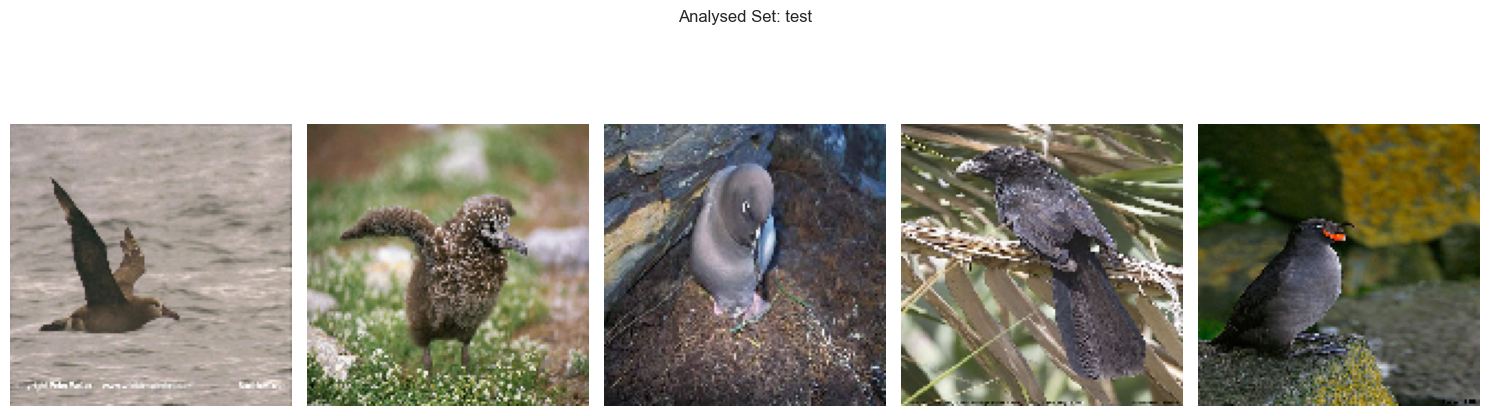

Classes count in Set 'test': 200
Pictures count in Class (based on 5 classes): {'001.Black_footed_Albatross': 4, '002.Laysan_Albatross': 4, '003.Sooty_Albatross': 4, '004.Groove_billed_Ani': 4, '005.Crested_Auklet': 4}




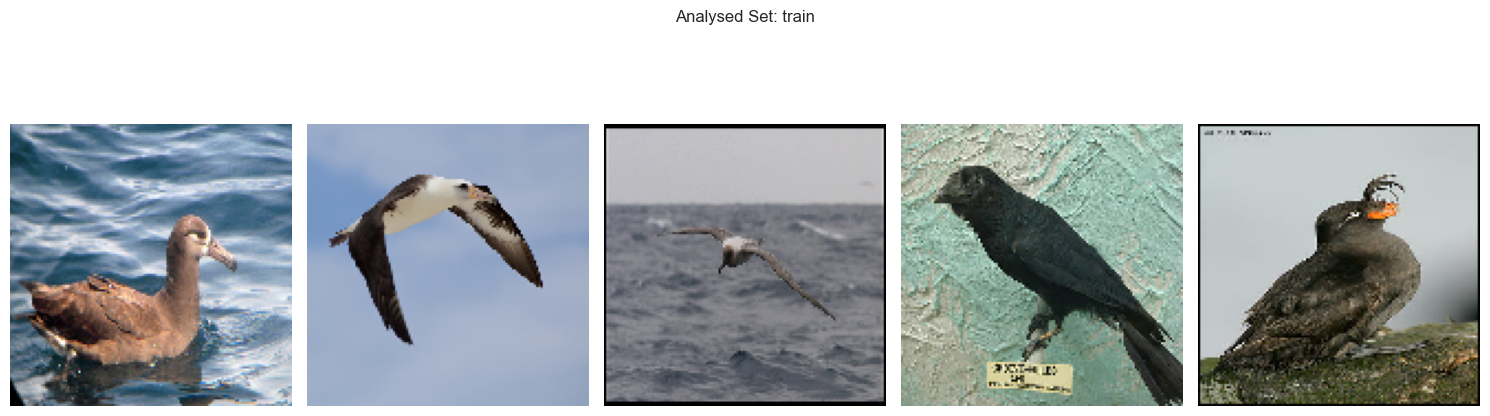

Classes count in Set 'train': 200
Pictures count in Class (based on 5 classes): {'001.Black_footed_Albatross': 32, '002.Laysan_Albatross': 32, '003.Sooty_Albatross': 32, '004.Groove_billed_Ani': 32, '005.Crested_Auklet': 32}




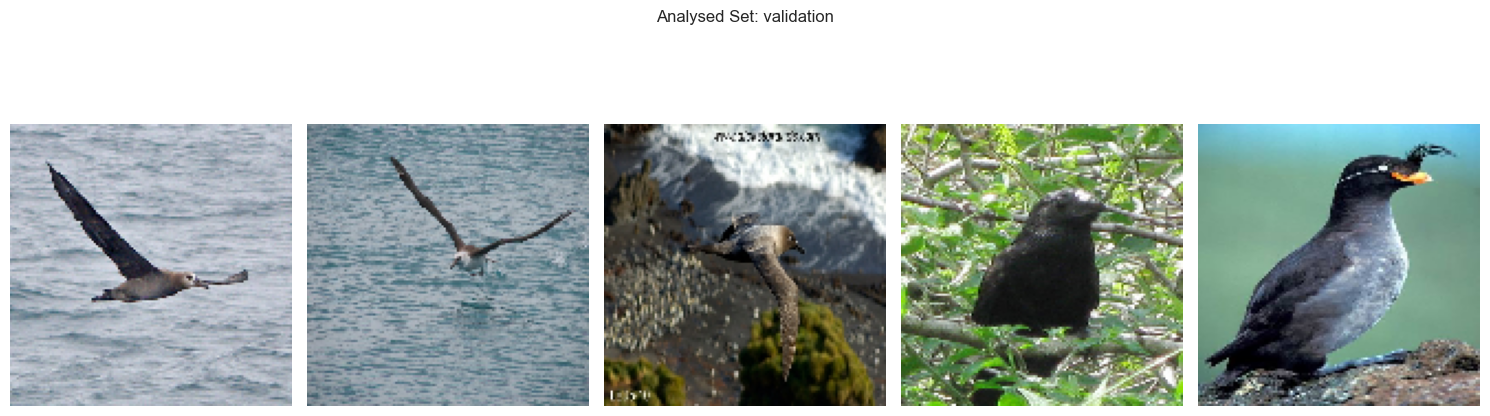

Classes count in Set 'validation': 200
Pictures count in Class (based on 5 classes): {'001.Black_footed_Albatross': 4, '002.Laysan_Albatross': 4, '003.Sooty_Albatross': 4, '004.Groove_billed_Ani': 4, '005.Crested_Auklet': 4}


Count of ouput Neurons in  CNN: 200
Found 6400 images belonging to 200 classes.
Found 800 images belonging to 200 classes.
Found 800 images belonging to 200 classes.


In [104]:
# Definovanie cesty k adresárom s obrázkami
birds_dataset = "bird_dataset"  # Cesta k priečinkom s obrázkami
classes_count = analyze_data(birds_dataset, NUM_CLASS_SAMPLES, (FULL_RES_HEIGHT, FULL_RES_WIDTH))

print(f"Count of ouput Neurons in  CNN: {classes_count}")

# Cesty k dátam
train_dir = birds_dataset + '/train'
val_dir = birds_dataset + '/validation'
test_dir = birds_dataset + '/test'

# Nastavenie ImageDataGenerator pre tréningové dáta s augmentáciou
train_gen = ImageDataGenerator(
    rescale=1./255,               # Normalizácia pixelov
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'          # Ako dopĺňať chýbajúce pixely (najbližšia hodnota)
)

# Nastavenie ImageDataGenerator pre validačné a testovacie dáta (bez augmentácie)
val_gen = ImageDataGenerator(rescale=1./255)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=2*BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=2*BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=2*BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

In [105]:
'''
# Hyperparametre pre testovanie
experiments_num = 3
first_layer_filters = [32, 32, 32]
second_layer_filters = [32, 64, 64]
thirth_layer_filters = [64, 64, 128]
denses = [256, 128, 256]
first_dropout_rates = [0.1, 0.25, 0.1]
second_dropout_rates = [0.1, 0.1, 0.1]
thirth_dropout_rates = [0.1, 0.1, 0.1]
dense_dropout_rates = [0.25, 0.25, 0.25]
learning_rates = [0.001, 0.001, 0.001]
results = []

# Testovanie rôznych konfigurácií hyperparametrov
for i in range(experiments_num):
    print(f'{i}. Testing model with :\nfirst_layer_filters={first_layer_filters[i]}\nsecond_layer_filters={second_layer_filters[i]}\nthirth_layer_filters={thirth_layer_filters[i]}\ndenses={denses[i]}first_dropout={first_dropout_rates[i]}\nsecond_dropout={second_dropout_rates[i]}\nthirth_dropout_rate={thirth_dropout_rates[i]}\ndense_dropout_rate={dense_dropout_rates[i]}\nlearning_rate={learning_rates[i]}')

    trained_experiment_model = train_cnn_model(classes_count, first_layer_filters[i], second_layer_filters[i], thirth_layer_filters[i], denses[i], first_dropout_rates[i], second_dropout_rates[i], thirth_dropout_rates[i], dense_dropout_rates[i], learning_rates[i], CNN_EPOCHS)
    experiments_model =       trained_experiment_model[0]
    experiments_history =     trained_experiment_model[1]
    experiments_train_acc =   trained_experiment_model[2]
    experiments_test_acc =    trained_experiment_model[3]
    experiments_val_acc =     trained_experiment_model[4]
    experiments_train_loss =  trained_experiment_model[5]
    experiments_test_loss =   trained_experiment_model[6]
    experiments_val_loss =    trained_experiment_model[7]

    results.append({
        'model': experiments_model,
        'history': experiments_history,
        'first_layer_filters': first_layer_filters[i],
        'second_layer_filters': second_layer_filters[i],
        'thirth_layer_filters': thirth_layer_filters[i],
        'denses': denses[i],
        'first_dropout_rate': first_dropout_rates[i],
        'second_dropout_rate': second_dropout_rates[i],
        'thirth_dropout_rate': thirth_dropout_rates[i],
        'dense_dropout_rate': dense_dropout_rates[i],
        'learning_rate': learning_rates[i],
        'train_acc': experiments_train_acc,
        'test_acc': experiments_test_acc,
        'val_acc': experiments_val_acc,
        'train_loss':  experiments_train_loss,
        'test_loss': experiments_test_loss,
        'val_loss': experiments_val_loss,
    })

    print(f"Training Accuracy: {experiments_train_acc:.2f}, Training Loss: {experiments_train_loss:.2f}")
    print(f"Testing Accuracy: {experiments_test_acc:.2f}, Testing Loss: {experiments_test_loss:.2f}")
    print(f"Validation Accuracy: {experiments_val_acc:.2f}, ValidationLoss: {experiments_val_loss:.2f}")

# Vytvorenie tabuľky s výsledkami
results_dataframe = pd.DataFrame(results)
print(results_dataframe.drop(columns=['model', 'history']))
'''

0. Testing model with :
first_layer_filters=32
second_layer_filters=32
thirth_layer_filters=64
denses=256first_dropout=0.1
second_dropout=0.1
thirth_dropout_rate=0.1
dense_dropout_rate=0.25
learning_rate=0.001


C:\Program Files\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 940ms/step - accuracy: 0.0052 - loss: 5.7642 - val_accuracy: 0.0012 - val_loss: 8.9366
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.0047 - loss: 5.2987 - val_accuracy: 0.0088 - val_loss: 6.4316
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.0040 - loss: 5.2998 - val_accuracy: 0.0075 - val_loss: 5.5117
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.0052 - loss: 5.2986 - val_accuracy: 0.0037 - val_loss: 5.3753
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.0038 - loss: 5.2987 - val_accuracy: 0.0037 - val_loss: 5.3275
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 993ms/step - accuracy: 0.0050 - loss: 5.2986 - val_accuracy: 0.0050 - val_loss: 5.3151
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.0042 - loss: 5.2988 - val_accuracy: 0.0050 - val_loss: 5.3016
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 814ms/step - accuracy: 0.0030 - loss: 5.3011 - v


Best model (based on Testing Accuracy): 
train_acc=0.005781250074505806
test_acc=0.004999999888241291
val_acc=0.0062500000931322575
learning_rate=0.001


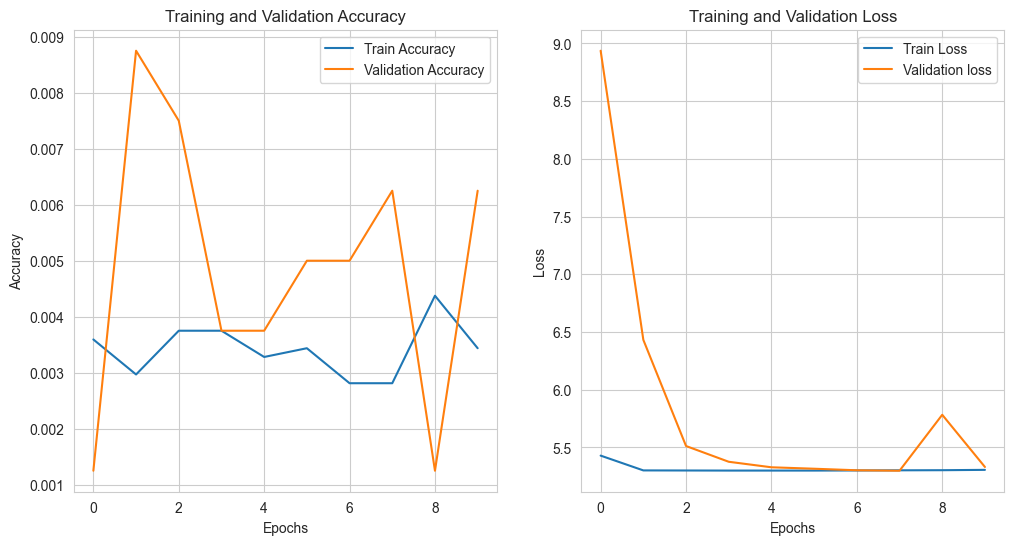

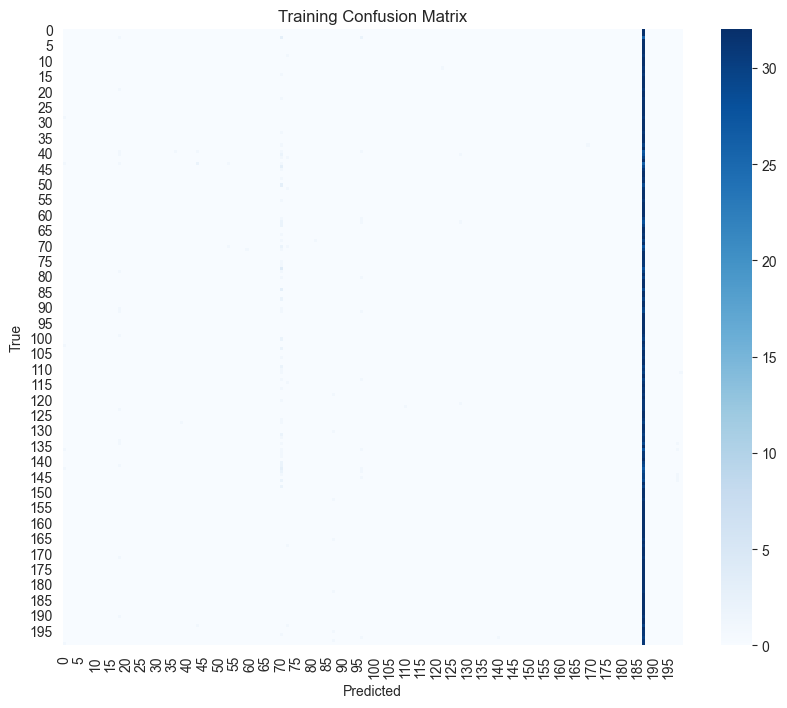

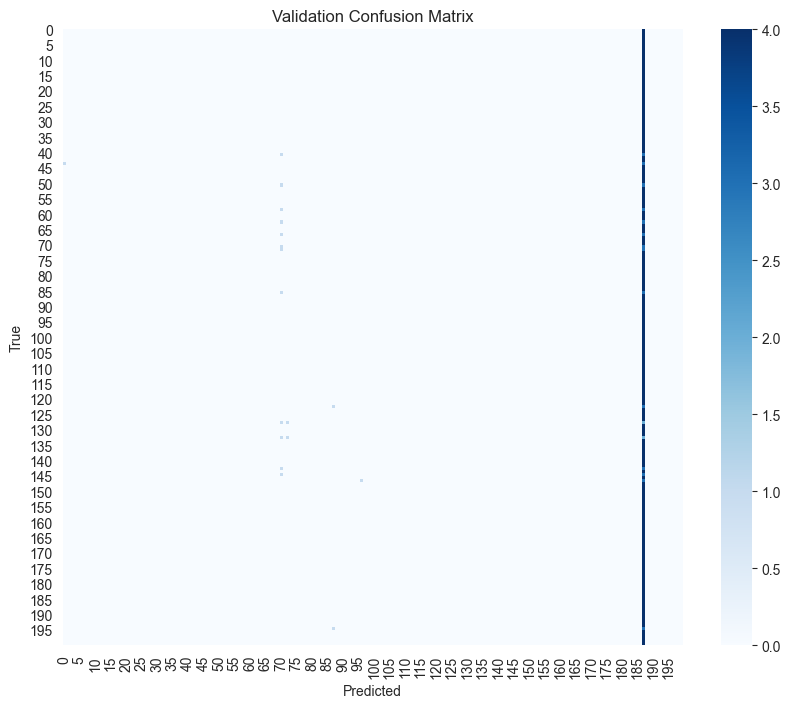

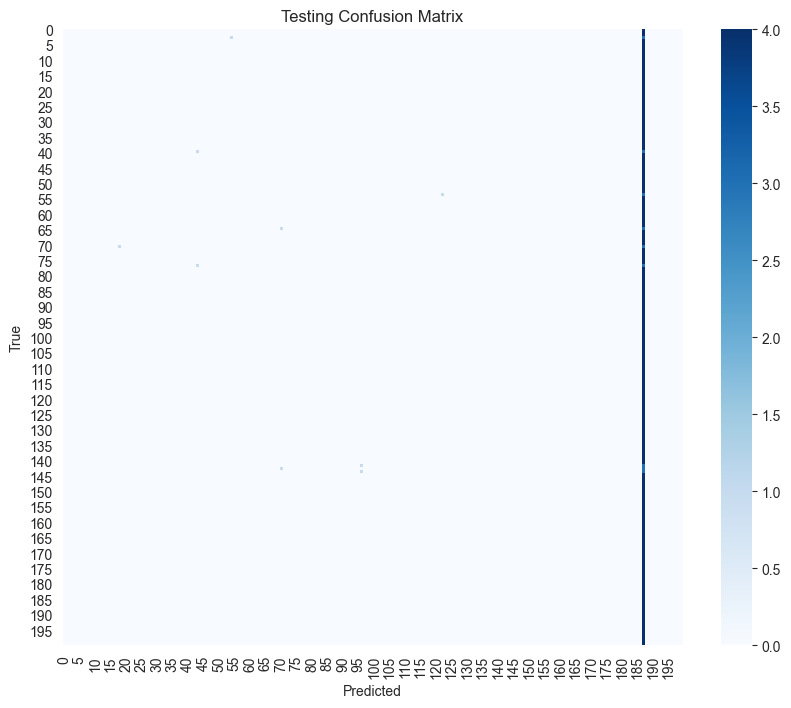

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [106]:
# Vyberte najlepší model podľa test_acc
best_model_row = results_dataframe.loc[results_dataframe['test_acc'].idxmax()]
best_first_dropout = best_model_row['first_dropout_rate']
best_second_dropout = best_model_row['second_dropout_rate']
best_thirth_dropout = best_model_row['thirth_dropout_rate']
best_dense_dropout = best_model_row['dense_dropout_rate']
best_learning_rate = best_model_row['learning_rate']

# Načítajte najlepší model
best_model =       best_model_row['model']
best_history =     best_model_row['history']
best_train_acc =   best_model_row['train_acc']
best_test_acc =    best_model_row['test_acc']
best_val_acc =     best_model_row['val_acc']
best_train_loss =  best_model_row['train_loss']
best_test_loss =   best_model_row['test_loss']
best_val_loss =    best_model_row['val_loss']

print(f'\nBest model (based on Testing Accuracy): \ntrain_acc={best_train_acc}\ntest_acc={best_test_acc}\nval_acc={best_val_acc}\nlearning_rate={best_learning_rate}')

plot_training(best_history)
plot_confusion_matrix_shuffle(best_model, train_data, title='Training Confusion Matrix')
plot_confusion_matrix_shuffle(best_model, val_data, title='Validation Confusion Matrix')
plot_confusion_matrix_nonshuffle(best_model, test_data, title='Testing Confusion Matrix')

In [109]:
# Načítanie modelu MobileNet pre extrakciu príznačkov
pretrained_model = MobileNet(include_top=False, weights='imagenet', input_shape=(FULL_RES_HEIGHT, FULL_RES_WIDTH, 3))
total_layers = len(pretrained_model.layers)

print(f'Total count of ImageNet layers: {total_layers}')

pretrained_model.trainable = False
birds_dataframe = dataset_to_dataframe(birds_dataset, pretrained_model)

# Uistenie sa, že posledných 20 vrstiev je trainable
for layer in pretrained_model.layers[total_layers - 20:]:
    layer.trainable = True

birds_dataframe = dataset_to_dataframe(birds_dataset, pretrained_model)
birds_dataframe.to_csv(FEATURES_DATASET_NAME + "_n", index=False)

# Zníženie dimenzie pomocou PCA
generated_features = birds_dataframe.filter(like="feature_").values
pca = PCA(n_components=NUM_COMP_PCA)
reduced_features = pca.fit_transform(generated_features)

# K-Means clustering
kmeans = KMeans(n_clusters=NUM_CLUST, random_state=RAND_ST)
clusters = kmeans.fit_predict(reduced_features)

# Pridanie zhlukov do DataFrame
birds_dataframe['cluster'] = clusters
birds_dataframe.to_csv(FEATURES_DATASET_NAME, index=False)

# Vizualizácia 5 obrazkov na 1 zhluk (dokopy NUM_CLUST), vratane priemerneho
for cluster_id in range(NUM_CLUST):
    plot_cluster_images(birds_dataframe, cluster_id, IMAGES_PER_CLUSTER)

    avg_img = compute_cluster_average(birds_dataframe, cluster_id, (FULL_RES_HEIGHT, FULL_RES_WIDTH))
    plt.imshow(avg_img)
    plt.axis('off')
    plt.title(f"Average Image per Cluster {cluster_id}")
    plt.show()

cluster_visualization(birds_dataframe, "t-SNE Cluster Visualization for Transfer Learning")

# Dotrenovanie
trained_classificator = transfer_learning_model(pretrained_model, classes_count, 64, 0.25, 0.001, TL_EPOCHS)
classificator_model = trained_classificator[0]
classificator_history = trained_classificator[1]
classificator_train_acc = trained_classificator[2]
classificator_test_acc = trained_classificator[3]
classificator_val_acc = trained_classificator[4]
classificator_train_loss = trained_classificator[5]
classificator_test_loss = trained_classificator[6]
classificator_val_loss = trained_classificator[7]

print(f'Training Accuracy: {classificator_train_acc}, Validation Accuracy: {classificator_val_acc}, Test Accuracy: {classificator_test_acc}')
print(f'Training Loss: {classificator_train_loss}, Validation Loss: {classificator_val_loss}, Test Loss: {classificator_test_loss}')

plot_training(classificator_history)
plot_confusion_matrix_shuffle(classificator_model, train_data, title='Training Confusion Matrix')
plot_confusion_matrix_shuffle(classificator_model, val_data, title='Validation Confusion Matrix')
plot_confusion_matrix_nonshuffle(classificator_model, test_data, title='Testing Confusion Matrix')

Total count of ImageNet layers: 86


KeyboardInterrupt: 

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.2677 - loss: 2.1233 - val_accuracy: 0.7250 - val_loss: 0.9613
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5620 - loss: 1.2634 - val_accuracy: 0.8100 - val_loss: 0.6303
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6893 - loss: 0.9122 - val_accuracy: 0.8537 - val_loss: 0.5068
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.7609 - loss: 0.7205 - val_accuracy: 0.8637 - val_loss: 0.4504
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7974 - loss: 0.5942 - val_accuracy: 0.8687 - val_loss: 0.3946
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8384 - loss: 0.4897 - val_accuracy: 0.8800 - val_loss: 0.3565
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8694 - loss: 0.4104 - val_accuracy: 0.8675 - val_loss: 0.3555
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8944 - loss: 0.3247 - 

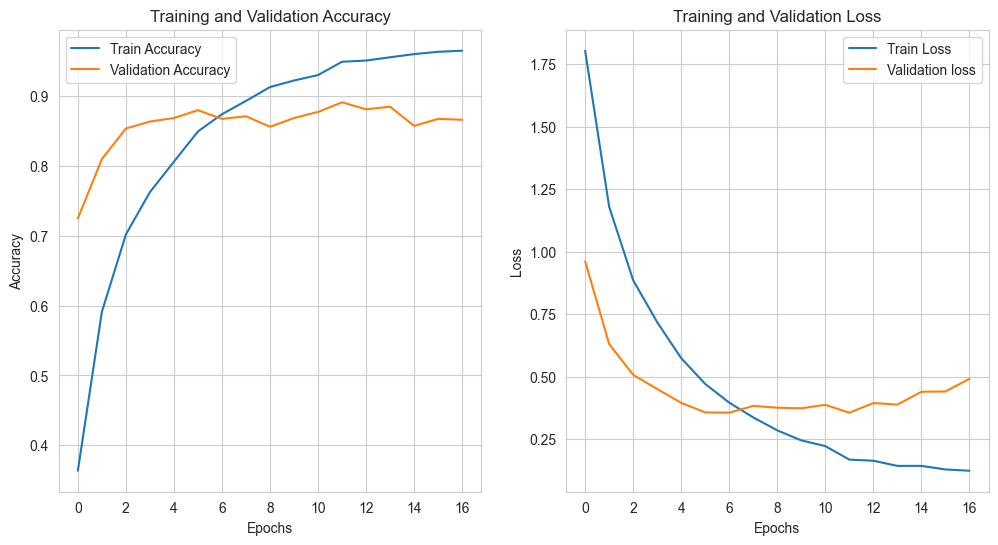

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


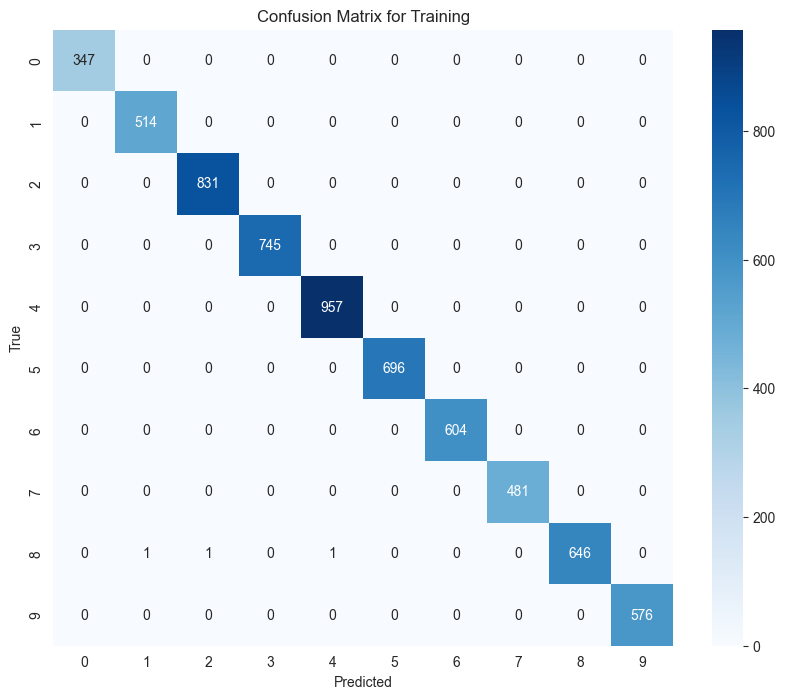

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


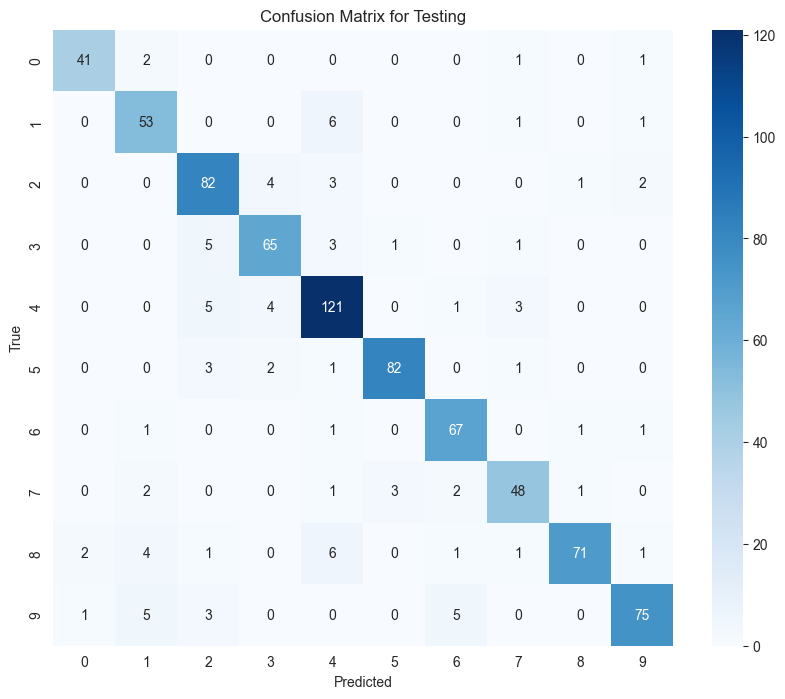

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


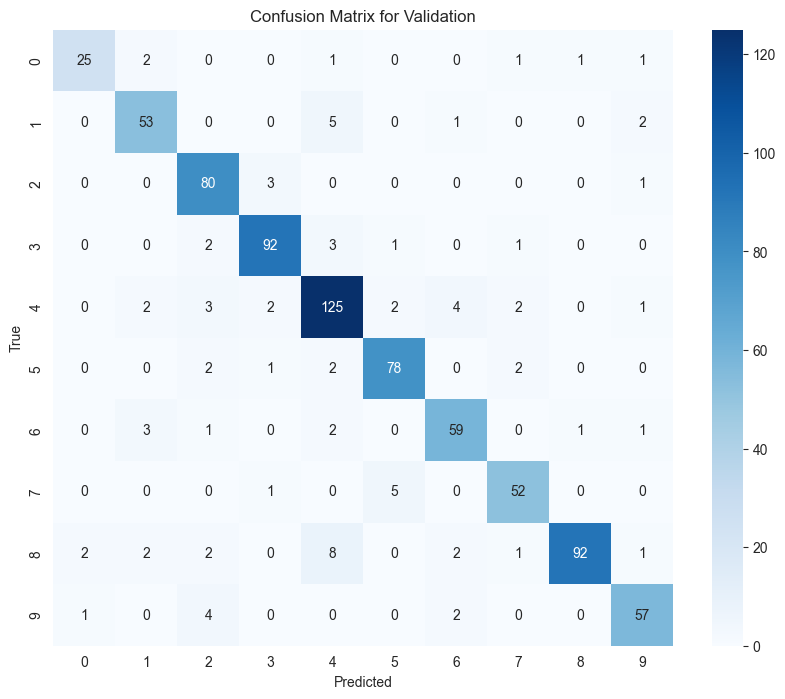

Accuracy for Cluster 0: 0.9111
Accuracy for Cluster 1: 0.8689
Accuracy for Cluster 2: 0.8913
Accuracy for Cluster 3: 0.8667
Accuracy for Cluster 4: 0.9030
Accuracy for Cluster 5: 0.9213
Accuracy for Cluster 6: 0.9437
Accuracy for Cluster 7: 0.8421
Accuracy for Cluster 8: 0.8161
Accuracy for Cluster 9: 0.8427

The best performing cluster is Cluster 6 with accuracy 0.9437
The worst performing cluster is Cluster 8 with accuracy 0.8161


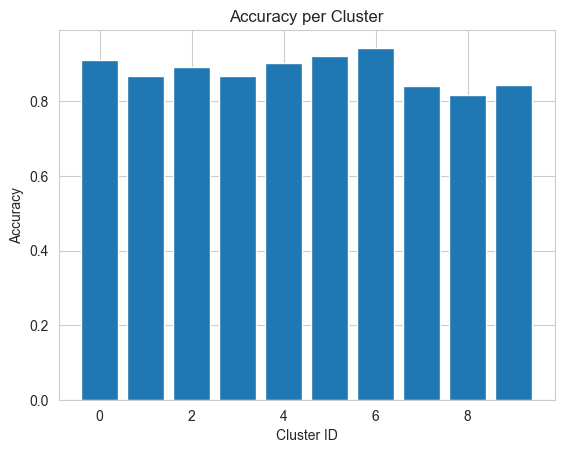

In [110]:
neural_dataframe = birds_dataframe

#neural_read_data = pd.read_csv(FEATURES_DATASET_NAME)
#neural_dataframe = pd.DataFrame(neural_read_data)
neural_dataframe.drop(columns=['class'], inplace=True)
neural_dataframe.drop(columns=['set'], inplace=True)
neural_dataframe.drop(columns=['path'], inplace=True)

X = neural_dataframe.drop(columns=['cluster'])
clusters = neural_dataframe['cluster']
Y = to_categorical(clusters)

neural_network = neural_network_model(X, Y, NUM_CLUST, 128, 0.3, 64, 0.2, 32, 0.2, 0.2, 0.5, 0.0001, RAND_ST, NN_EPOCHS)
neural_model = neural_network[0]
neural_history = neural_network[1]
neural_x_train = neural_network[2]
neural_x_val = neural_network[3]
neural_x_test = neural_network[4]
neural_train_acc = neural_network[5]
neural_test_acc = neural_network[6]
neural_val_acc = neural_network[7]
neural_train_loss = neural_network[8]
neural_test_loss = neural_network[9]
neural_val_loss = neural_network[10]
neural_y_train = neural_network[11]
neural_y_test  = neural_network[12]
neural_y_val = neural_network[13]

print(f"Training Accuracy: {neural_train_acc:.2f}, Training Loss: {neural_train_loss:.2f}")
print(f"Testing Accuracy: {neural_test_acc:.2f}, Testing Loss: {neural_test_loss:.2f}")
print(f"Validation Accuracy: {neural_val_acc:.2f}, Validation Loss: {neural_val_loss:.2f}")

plot_training(neural_history)

# Vytvorenie konfúznej matice
plot_confusion_matrix(neural_model, neural_x_train, neural_y_train, 'Confusion Matrix for Training')
nn_test_cm = plot_confusion_matrix(neural_model, neural_x_test, neural_y_test, 'Confusion Matrix for Testing')
plot_confusion_matrix(neural_model, neural_x_val, neural_y_val, 'Confusion Matrix for Validation')

# Získanie počtu správnych predikcií pre každý zhluk
correct_predictions_per_cluster = np.diag(nn_test_cm)  # Diagonálne prvky - správne predikcie
total_per_cluster = np.sum(nn_test_cm, axis=1)  # Suma riadkov - celkový počet prípadov pre každý zhluk

# Presnosť pre každý zhluk
accuracy_per_cluster = correct_predictions_per_cluster / total_per_cluster

# Zobrazenie presnosti pre každý zhluk
for cluster_id, accuracy in enumerate(accuracy_per_cluster):
    print(f"Accuracy for Cluster {cluster_id}: {accuracy:.4f}")

print("")

# Zistenie najlepšej a najhoršej triedy
best_cluster = np.argmax(accuracy_per_cluster)
worst_cluster = np.argmin(accuracy_per_cluster)

print(f"The best performing cluster is Cluster {best_cluster} with accuracy {accuracy_per_cluster[best_cluster]:.4f}")
print(f"The worst performing cluster is Cluster {worst_cluster} with accuracy {accuracy_per_cluster[worst_cluster]:.4f}")

# Vizualizácia presnosti pre každý zhluk
plt.bar(range(len(accuracy_per_cluster)), accuracy_per_cluster)
plt.xlabel('Cluster ID')
plt.ylabel('Accuracy')
plt.title('Accuracy per Cluster')
plt.show()